In [11]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## To Do: 
Do research on augmentations 
and decide to fix trainloader. Make my own train loader class if needed. 

## Get rid of the ordering of the bounding boxes that can cause the problem.

### What is collate_fn what does it do.

* Model: 
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

https://www.geeksforgeeks.org/python-opencv-cv2-rectangle-method/ 

https://stackoverflow.com/questions/56108183/python-opencv-cv2-drawing-rectangle-with-text

small images


bounding_box_dict = dict() #COntain cols 1, 2, 3, 4
{"*.jpeg": [[67, 47, 110, 117], [70, 30, 83, 34], [160, 46, 59, 63]], "*.jpeg"}
label_dict = dict() #COntains dummy variable of strawberry, blackspot
{"*.jpeg": [1, 1, 0, }
Update bouding box then update label in the for loop.
print(strawberry_csv["FreshStrawberries90.jpeg"])

In [3]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Baby Dataset Fruit Defects Dataset .zip", 'r') as zip_ref:
    zip_ref.extractall()

In [169]:
#For one strawberry batch please drop watermark rows
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, rottenApple_csv_batch_2, rottenApple_csv_batch_3]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))
assert total_row_sum_check == fruit_df.shape[0]
print("DataFrame shape: {}".format(fruit_df.shape))
print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))
  


Checked total rows from all the dataframes combined: 526
DataFrame shape: (526, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots']
Number of Unique Images 159


In [170]:
# def order_bb(bb_coord):
#   x_coord = [bb_coord[0], bb_coord[2]]
#   y_coord = [bb_coord[1], bb_coord[3]]
#   return [min(x_coord), min(y_coord), max(x_coord), max(y_coord)]
  
bounding_box_dict = dict()
labels_dict = dict()
classes = ["Bad_Spots", "Strawberry", "Apples"]

# for row_index in range(len(fruit_df)): 
#   current_image_file = fruit_df.iloc[row_index]["Image_id"]
#   if current_image_file not in bounding_box_dict:
#     bounding_box_dict[current_image_file] = list()
#     labels_dict[current_image_file] = list()
#   bounding_box_dict[current_image_file].append(order_bb(fruit_df.iloc[row_index, 1:5].to_list()))
#   labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))

159
159


### Example Pseudo code for an image

For the image below we need 6 bounding boxes for example
Model forms 8. 

https://debuggercafe.com/faster-rcnn-object-detection-with-pytorch/

``` 
labels = ["Badspots", "Apples"]
labels (after processing) = [0, 1]

output = [{"boxes": [[], [], [], [], [], [], [], []],
          "labels": [0, 0, 0, 0, 1, 1, 0, 0, 0] #Predicted 6 bounding boxes and 2 apples. 
          "scores": [0.98, 0.95 ... 0.05 ] #Here we set a threshold so that bounding boxes with low confidence score are discarded.]            
```
The length of bouding box is determined by the batch size          

Then get the category names

```
class_names = ["Bad_Spots", "Apples", "Bananas", "Strawberry"]
```

Model pretrained load only for (Coco) * Important b/c we need to train on our datatset not on the Coco dataset
```
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, 
                                                    min_size=args['min_size'])
```


In [ ]:
sorted(labels_dict.keys())[20]

'FreshStrawberries37.jpeg'

get a for loop and loop throufh each image key create a new word 
so like 
a then ap then app then appl then apple and check if each word is in the folder name. 

* get the keys of the dictionary and then put in into self.imgs list. 
Now I can use if statements to build the root. 

Now i have a list of keys
So I can access the bouding boxes and the label list using that key

Create a dataframe with image_keys and roots.

## more Psedo code

Use glob glob to find all the image paths then I can say:
[list of of image paths inside Train]

only one file patg that will end FreshStrawberries37.jpeg

for file_path in glob_path:
  if image_key in file_path (get stuff before last backslash): ("Strawberry")
  then return that file_path
  return file_path

In [165]:
ffile_path("FreshStrawberries15.jpeg", train_dataset.full_image_file_paths)

In [166]:
ffile_path("FreshStrawberries10.jpeg", train_dataset.full_image_file_paths)

'/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/FreshStrawberries10.jpeg'

In [168]:
labels_dict["FreshStrawberries15.jpeg"]

[1, 1]

## Class function

In [171]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(pair_of_coord[2] * pair_of_coord[3])
  return area_of_each_bb

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())
    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths)

    # print(img_path)
    # print(idx)
    # print(self.imgs_key[idx])
    
    img = Image.open(img_path).convert("RGB") ## No Image path sometimes

    boxes = torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32)
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      img = self.transforms(img)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

### The Problem involved the differences between tensor, PIL, Numpy, and OpenCV and how they load images. 

Convert Tensor Image to numpy to do openCV operations. 
https://discuss.pytorch.org/t/convert-image-tensor-to-numpy-image-array/22887/2

PIL Loaded (y, x)
Numpy (x, y, d)
Torch (d, x, y) <- convert image to tensor and switch axis
Then convert to openCV since openCV can handle only a numpy array. 

Questions: 
Do I have to apply transforms on the labels/ boxes. I see it on the blog but I can't do it. 

Also, why when I take off shuffle does the dateiter fail. Why does it sometimes get a None error.

What I think is that the tensor image is ok. The reason the image flipped is because I Transposed it. When I did not transpose it, the openCV could recognize it b/c it only works well with the numpy shaped images. Therefore, all my code did was to turn that tensor image into something compatible with OpenCV so it can do its manipulations.

In [172]:
def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

np.random.seed(42)
torch.manual_seed(42)
batch_size = 32

train_transform = transforms.Compose([
                                      transforms.ToTensor()])
                                      


train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, train_transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn= collate_fn)

In [173]:
COLORS = [(255, 0, 0) for i in range(len(classes))]
COLORS[0] = (0, 0, 255)

def draw_boxes(boxes, labels, image):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[0]) + int(box[2]), int(int(box[1])) + int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

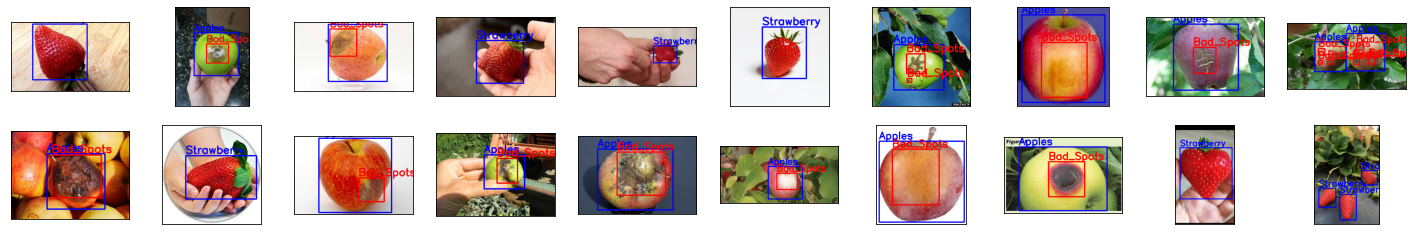

In [174]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = cv2.cvtColor(draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx]), cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [ ]:

# bounding_box_dict = dict()
# labels_dict = dict()
# classes = ["Black_Spots", "Strawberry"]

# for row_index in range(len(strawberry_csv)): 
#   current_image_file = strawberry_csv.iloc[row_index]["Image_id"]
#   if current_image_file not in bounding_box_dict:
#     bounding_box_dict[current_image_file] = list()
#     labels_dict[current_image_file] = list()
#   bounding_box_dict[current_image_file].append(strawberry_csv.iloc[row_index, 1:5].to_list())
#   labels_dict[current_image_file].append(classes.index(strawberry_csv.iloc[row_index, 0]))

